### Name : Asma Massad

# Assignment 2 - Classification MGC and QDA

**<font color="#FF0000" size=4>In this Assignment we will build two classifiers from scratch. The classifiers are Multivariate Gaussian Classifier (MGC) and quadratic discriminant analysis (QDA). Then we will compare their accuracy with classifierrs from sklearn (gaussianNB and SVC). After that, we will will use cross validation with different portions from the training set (10%, 20%, 30% .. etc).</font>**



In [102]:
import math
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score


%matplotlib inline  

### Data Loading

In [103]:
df = pd.read_csv('data/dataset.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.563180,0.889130,-0.066184,0.213090,-1.105378,-0.823811,0.572390,0.650379,-2.399465,0.967247,...,0.236133,1.067034,0.358328,-0.071513,0.033498,-0.397892,1.564167,0.796677,-0.589771,0
1,0.487244,0.723126,-0.410346,0.205746,-0.430689,0.556690,-0.282686,0.743213,3.568294,-1.304291,...,0.132833,-0.899875,-0.307589,-0.280787,0.636312,0.837123,0.653099,0.560830,1.603049,1
2,-1.216737,0.263227,0.047519,-0.691492,0.815702,-2.078070,0.979983,0.770997,1.036673,1.018810,...,-0.541987,-1.544878,0.397889,0.090999,1.117576,0.470238,0.404427,-1.624903,0.159953,1
3,-0.463679,-1.121463,2.008842,-0.651919,-0.254896,-1.157199,1.144751,0.986495,-0.084526,1.605068,...,-0.189889,0.233307,-0.480073,-0.179531,-1.808612,-1.308957,-1.150058,-0.310423,-0.749395,0
4,-1.170454,-0.439287,-0.327421,0.075073,-0.507101,0.455391,-0.399849,0.671238,0.981226,-0.999953,...,0.313305,0.158874,-1.858308,1.218167,-2.038434,-0.149545,0.307887,-2.271531,0.374542,2


In [104]:
df.shape

(15000, 21)

In [105]:
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
dtype: int64

In [106]:
df['20'].value_counts()

0    3762
1    3757
2    3743
3    3738
Name: 20, dtype: int64

**<font color=#FF0000 size=3> Creating training and testing sets </font>**

In [107]:
labelDF = df['20']
featuresDF = df.drop('20',axis=1)
featuresDF = featuresDF.to_numpy()
labelDF = labelDF.to_numpy()
trainX, testX, trainY, testY = train_test_split(featuresDF, labelDF,test_size=0.30, random_state=42)

# Part 1 - MGC vs GaussianNB

**<font color="#FF0000" size=4> Problem One: </font>**
    
   **<font color="#FF0000"  size=3> 1- Design and implement general Multivariate Gaussian classifier for multiclass classification using python. </font>**
   
   **<font color="#FF0000"  size=3> 2- Compare your implementation with the Gaussian implemented in sklearn library “class sklearn.naive_bayes.GaussianNB()” using the accuracy measure </font>**
   
   **<font color="#FF0000"  size=3> 3- Use cross validation technique on train set to draw the training and validation error using different portions of the training set as instructed in the assignment file.  </font>**


 ### 1 - Multivariate Gaussian Classifier (MGC)

<font size=3> The multivariate Gaussian distribution with mean µ and covariance matrix Σ, has the following probability density function: </font>

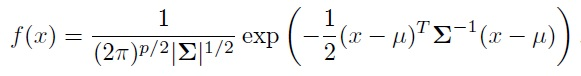

In [108]:
class MGC:
    def __init__(self, temp_param='temp'):
        """I'm using temp_param for get_param method,
           so I can later use the learning_curves tool from sklearn which requires get_params()
        """
        self.temp_param = temp_param

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.xlen, self.num_features = X.shape
        self.mean = [[0 for _ in range(self.num_features)] for _ in range(self.n_classes)]
        self.std = [np.identity(self.num_features) for _ in range(self.n_classes)]

        self.class_list, counts = np.unique(y, return_counts=True)
        self.prior = counts / len(y)

        class_index = []
        
        for i in range(self.n_classes):
            index = np.argwhere(y == self.class_list[i])
            selected_row = X[index, :]
            class_index.append(list(index[:, 0]))
            self.mean[i] = np.sum(selected_row, axis=0) / counts[i]

        diag_i = np.diag_indices(self.num_features)
       
        for i in range(self.n_classes):
            selected_row = X[class_index[i], :]
            mean_arr = np.repeat(self.mean[i], selected_row.shape[0], axis=0)
            diff = selected_row - mean_arr
            diag = np.diag(np.matmul(diff.T, diff)) / counts[i]
            self.std[i][diag_i] = diag
        
        for i in range(self.n_classes):
            if np.linalg.det(self.std[i]) == 0:
                epsilon = 1e-9
                eps = np.identity(self.d) * epsilon
                self.std[i] = self.std[i] + eps
    
    def predict(self, X):
        n = X.shape[0]
        pred_list = np.zeros((n, self.n_classes))
        pred = np.zeros(n)
        for j in range(self.n_classes):
            for i in range(X.shape[0]):
                part = X[i, :] - self.mean[j]
                pred_list[i, j] = -1 / 2 * (math.log(np.linalg.det(self.std[j]))) - 1 / 2 * np.linalg.multi_dot(
                    [part, np.linalg.inv(self.std[j]), part.T]) + (math.log(self.prior[j]))
        for i in range(X.shape[0]):
            pred[i] = self.class_list[int(np.argmax(pred_list[i, :]))]
        return pred
    
    def score(self, X, y):
        predictions=self.predict(X)
        n=len(y)
        return(predictions==y).sum()/n
    
    def get_params(self,deep=True):
        def_param = "noParam"
        return {"temp_param": self.temp_param}

In [109]:
mgc_clf = MGC()
mgc_clf.fit(trainX, trainY)
mgc_clf_pred = mgc_clf.predict(testX)

In [110]:
print(mgc_clf.score(testX,testY))

0.758


### 2 - Sklearn GaussianNB

In [111]:
gaussNB_clf = GaussianNB()
gaussNB_clf.fit(trainX, trainY)

GaussianNB()

In [112]:
gaussNB_clf_predY = gaussNB_clf.predict(testX)

In [113]:
clf_report = classification_report(testY, gaussNB_clf_predY)
print(clf_report)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1155
           1       0.75      0.82      0.79      1096
           2       0.76      0.72      0.74      1091
           3       0.73      0.73      0.73      1158

    accuracy                           0.76      4500
   macro avg       0.76      0.76      0.76      4500
weighted avg       0.76      0.76      0.76      4500



**<font color="#FF0000" size=3> MGC & GaussianNB Accuracy Comparison </font>**

In [114]:
print('MGC Accuracy: %.2f' % (mgc_clf.score(testX,testY)*100), "%")
print('GaussianNB Accracy: %.2f' % (gaussNB_clf.score(testX,testY)*100), "%")

MGC Accuracy: 75.80 %
GaussianNB Accracy: 75.80 %


**<font color="FF0000" size=3> Note:</font>** 
GaussianNB has two hyperparameters epsilon and "priors" which is prior probabilities of the classes. If specified the priors are not adjusted according to the data(in our case we calculated according to the data). In our classifier MGC we used the same default value of epsilon as in the GaussianNB, and we calculated the priors and didn't provid a predefined ones. And since both classifiers uses the same underlying mathematics, the results were identical.  

### 3- Cross Validation

In [115]:
train_sizes_list = np.linspace(0.1, 1.0, 10)
train_sizes_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [116]:
train_sizes, MGC_train_scores, MGC_valid_scores = learning_curve(MGC(), trainX, trainY, train_sizes=train_sizes_list, cv=10)

In [117]:
train_sizes, gaussNB_train_scores, gaussNB_valid_scores = learning_curve(GaussianNB(), trainX, trainY, train_sizes=train_sizes_list, cv=10)

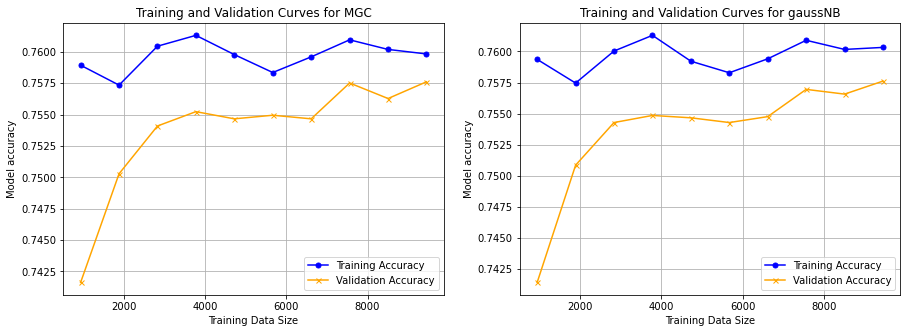

In [118]:
# Plot the training and validation curves

MGC_train_mean = np.mean(MGC_train_scores, axis=1)
MGC_val_mean = np.mean(MGC_valid_scores, axis=1)

gaussNB_train_mean = np.mean(gaussNB_train_scores, axis=1)
gaussNB_val_mean = np.mean(gaussNB_valid_scores, axis=1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1) 
plt.plot(train_sizes, MGC_train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes, MGC_val_mean, color='orange', marker='x', markersize=5, label='Validation Accuracy')
plt.title('Training and Validation Curves for MGC')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(train_sizes, gaussNB_train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes, gaussNB_val_mean, color='orange', marker='x', markersize=5, label='Validation Accuracy')
plt.title('Training and Validation Curves for gaussNB')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')

**<font color="FF0000" size=3> Results:</font>** 
**<font size=3>  When training sample size less than 2000, the difference between training and validation accuracy is much larger, and this indicates overfitting issues. However, for training size greater than 2000, the model is better. It is a sign of good bias-variance trade-off.</font>**

# Part 2 - QDA vs SVC

**<font color="#FF0000" size=4> Problem Two: </font>**
    
   **<font color="#FF0000"  size=3> 1- Design and implement general quadratic discriminant analysis (QDA) classifier for multiclass classification using python. </font>**
   
   **<font color="#FF0000"  size=3> 2- Compare your implementation of the second algorithm (QDA) with the SVM implemented in sklearn library “class sklearn.svm.SVC ( )”  using the accuracy measure. </font>**
   
   **<font color="#FF0000"  size=3> 3- Use cross validation technique on train set to draw the training and validation error using different portions of the training set as instructed in the assignment file.  </font>**


### 1- Quadratic Discriminant Analysis (QDA)

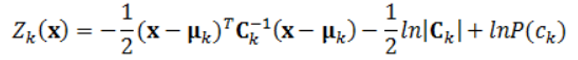

In [119]:
class QDA:
    def __init__(self, temp_param='temp'):
        """I'm using temp_param for get_param method,
           so I can later use the learning_curves tool from sklearn which requires get_params()
        """
        self.temp_param = temp_param
    
    def fit(self, X, y):
        self.prior_arr = []
        self.mean_arr = []
        self.cov_arr = []
        
        self.classes = np.unique(y)

        for i in self.classes:
            x_in_class = X[y == i]
            self.prior_arr.append( x_in_class.shape[0] / X.shape[0])
            self.mean_arr.append(np.mean(x_in_class, axis=0))
            self.cov_arr.append(np.cov(x_in_class, rowvar=False)) 

    def predict(self, X):
        pred_arr = []
        for x in X:
            post_arr = []
            for i in self.classes:
                prior = np.log(self.prior_arr[i])
                inv_cov = np.linalg.inv(self.cov_arr[i])
                inv_cov_det = np.linalg.det(inv_cov)
                diff = x-self.mean_arr[i]
                post = 0.5*np.log(inv_cov_det) -( 0.5*np.linalg.multi_dot([diff.T,  inv_cov ,diff]))+ prior
                post_arr.append(post)
                
            pred = self.classes[np.argmax(post_arr)]
            pred_arr.append(pred)
        return np.array(pred_arr)
    
    def score(self, X, y):
        predictions=self.predict(X)
        n=len(y)
        return(predictions==y).sum()/n
    
    def get_params(self,deep=True):
        def_param = "noParam"
        return {"temp_param": self.temp_param}

In [120]:
qda = QDA()
qda.fit(trainX, trainY)
qda_preds = qda.predict(testX)

In [121]:
qda.score(testX,testY)

0.7608888888888888

### 2- Sklearn SVC


In [122]:
svc_clf = SVC(gamma='auto')
svc_clf.fit(trainX, trainY)

SVC(gamma='auto')

In [123]:
svc_predY = svc_clf.predict(testX)

In [124]:
svc_clf_report = classification_report(testY,svc_predY)
print(svc_clf_report)

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1155
           1       0.82      0.81      0.81      1096
           2       0.80      0.85      0.83      1091
           3       0.79      0.82      0.80      1158

    accuracy                           0.81      4500
   macro avg       0.82      0.81      0.81      4500
weighted avg       0.82      0.81      0.81      4500



**<font color="#FF0000" size=3> QDA & SVC Accuracy Comparison </font>**

In [125]:
print('QDA Accuracy: %.2f' % (qda.score(testX,testY)*100), "%")
print('SVC Accracy: %.2f' % (svc_clf.score(testX,testY)*100), "%")

QDA Accuracy: 76.09 %
SVC Accracy: 81.42 %


**<font color="FF0000" size=3> Note:</font>** 
From the accuracy results we can conclude that even though QDA is computationally more efficient, still it underperforms in comparison to SVC.

### 3- Cross Validation 

In [126]:

train_sizes, QDA_train_scores, QDA_valid_scores = learning_curve(QDA(), trainX, trainY, train_sizes=train_sizes_list, cv=10)

In [127]:

train_sizes, SVC_train_scores, SVC_valid_scores = learning_curve(SVC(gamma='auto'), trainX, trainY, train_sizes=train_sizes_list, cv=10)

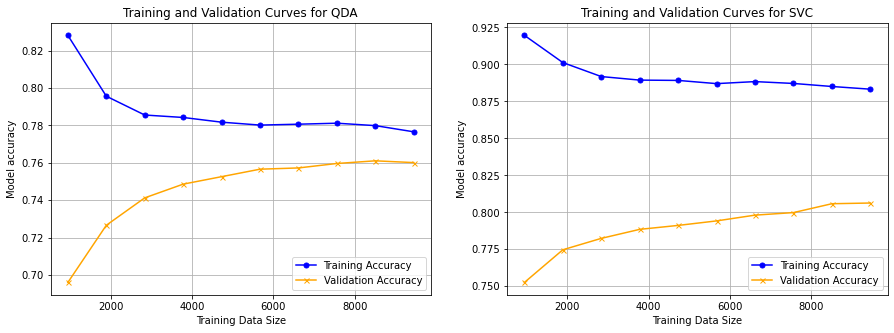

In [128]:
# Plot the training and validation curves

QDA_train_mean = np.mean(QDA_train_scores, axis=1)
QDA_val_mean = np.mean(QDA_valid_scores, axis=1)

SVC_train_mean = np.mean(SVC_train_scores, axis=1)
SVC_val_mean = np.mean(SVC_valid_scores, axis=1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1) 
plt.plot(train_sizes, QDA_train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes, QDA_val_mean, color='orange', marker='x', markersize=5, label='Validation Accuracy')
plt.title('Training and Validation Curves for QDA')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(train_sizes, SVC_train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes, SVC_val_mean, color='orange', marker='x', markersize=5, label='Validation Accuracy')
plt.title('Training and Validation Curves for SVC')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')

**<font color="FF0000" size=3> Results:</font>** 
**<font size=3>  When training sample size less than 4000, the difference between training and validation accuracy is much larger, an this indicates overfitting issues. However, for training size greater than 4000, the model is better. It is a sign of good bias-variance trade-off.</font>**
